In [1]:
import pandas as pd
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import  MLPClassifier, MLPRegressor

# XAI libraries
import dalex as dx
from lime.lime_tabular import LimeTabularExplainer 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Other libraries
# from utils import plotModelGridError, confusion_matrix
from neuralsens import partial_derivatives as ns
from sklearn import set_config
set_config(display='diagram')

### 1. Data load and split

In [2]:
def black_scholes_call_option(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    
    Parameters:
    S: Current stock price.
    K: Strike price of the option.
    T: Time to expiration in years.
    r: Risk-free interest rate (annualized).
    sigma: Volatility of the underlying stock (annualized).
    Returns:
        The Black-Scholes price of the call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S * si.norm.cdf(d1, 0.0, 1.0) - 
                  K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call_price


In [3]:
def greeks(S, K, T, r, sigma):
    """
    Calculate the Greeks of a European call option using the Black-Scholes model.
    
    Parameters:
    S: Current stock price.
    K: Strike price of the option.
    T: Time to expiration in years.
    r: Risk-free interest rate (annualized).
    sigma: Volatility of the underlying stock (annualized).
    
    Returns:
        A dictionary containing the Greeks: Delta, Gamma, Vega, Theta, Rho.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    delta = si.norm.cdf(d1)
    gamma = si.norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * si.norm.pdf(d1) * np.sqrt(T)
    theta = (-S * si.norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - 
             r * K * np.exp(-r * T) * si.norm.cdf(d2))
    rho = K * T * np.exp(-r * T) * si.norm.cdf(d2)
    
    return {
        'Delta': delta,
        'Gamma': gamma,
        'Vega': vega,
        'Theta': theta,
        'Rho': rho
    }

In [6]:
df = pd.read_csv('../data/test/synthetic_options_dataset.csv')
df_final = df.copy()

In [14]:
INPUTS = df_final.columns.drop(['call_price','r', 'delta', 'gamma', 'vega']).tolist()
TARGET = 'call_price'

X = df_final[INPUTS]
y = df_final[TARGET]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['midPrice'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['midPrice'] = y_test

### 2. MLP

#### A. Train model

In [35]:

# Escalado (como haces en tu TFM real)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()


mlp = MLPRegressor(hidden_layer_sizes=(60,), activation='tanh', solver='adam',
                   learning_rate_init=0.001, alpha=0.01, max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train_scaled)


MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(60,),
             max_iter=500, random_state=42)

In [36]:
# Evaluación rápida
from sklearn.metrics import mean_squared_error
y_pred_scaled = mlp.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

Test MSE: 1.6489


### 3. Neuralsense

In [24]:
mlp = mlp
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity','tanh',mlp.out_activation_]
X = scaler_X.fit_transform(X_train)
coefnames = ['num__S', 'num__K', 'num__T', 'num__sigma']


In [25]:
X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=[TARGET])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [26]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y,)

In [27]:
sensmlp.summary()

Sensitivity analysis of [4, 60, 1] MLP network.

Sensitivity measures of each output:

$call_price 

                mean       std  mean_squared
num__S      0.671496  0.423392      0.793831
num__K     -0.564912  0.418700      0.703161
num__T      0.105632  0.080849      0.133022
num__sigma  0.106914  0.080983      0.134122


In [28]:
sensmlp.info()

Sensitivity analysis of [4, 60, 1] MLP network.

8000 samples

Sensitivities of each output (only 5 first samples):

$call_price 

     num__S    num__K    num__T  num__sigma
0  1.182945 -1.037168 -0.038803    0.033941
1  0.650335 -0.549236  0.027592    0.024408
2  0.750498 -0.672571  0.050684    0.084023
3 -0.031788 -0.005095 -0.049620    0.084142
4  0.336129 -0.219786  0.036005    0.035540


/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/neuralsens/partial_derivatives.py:1749: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


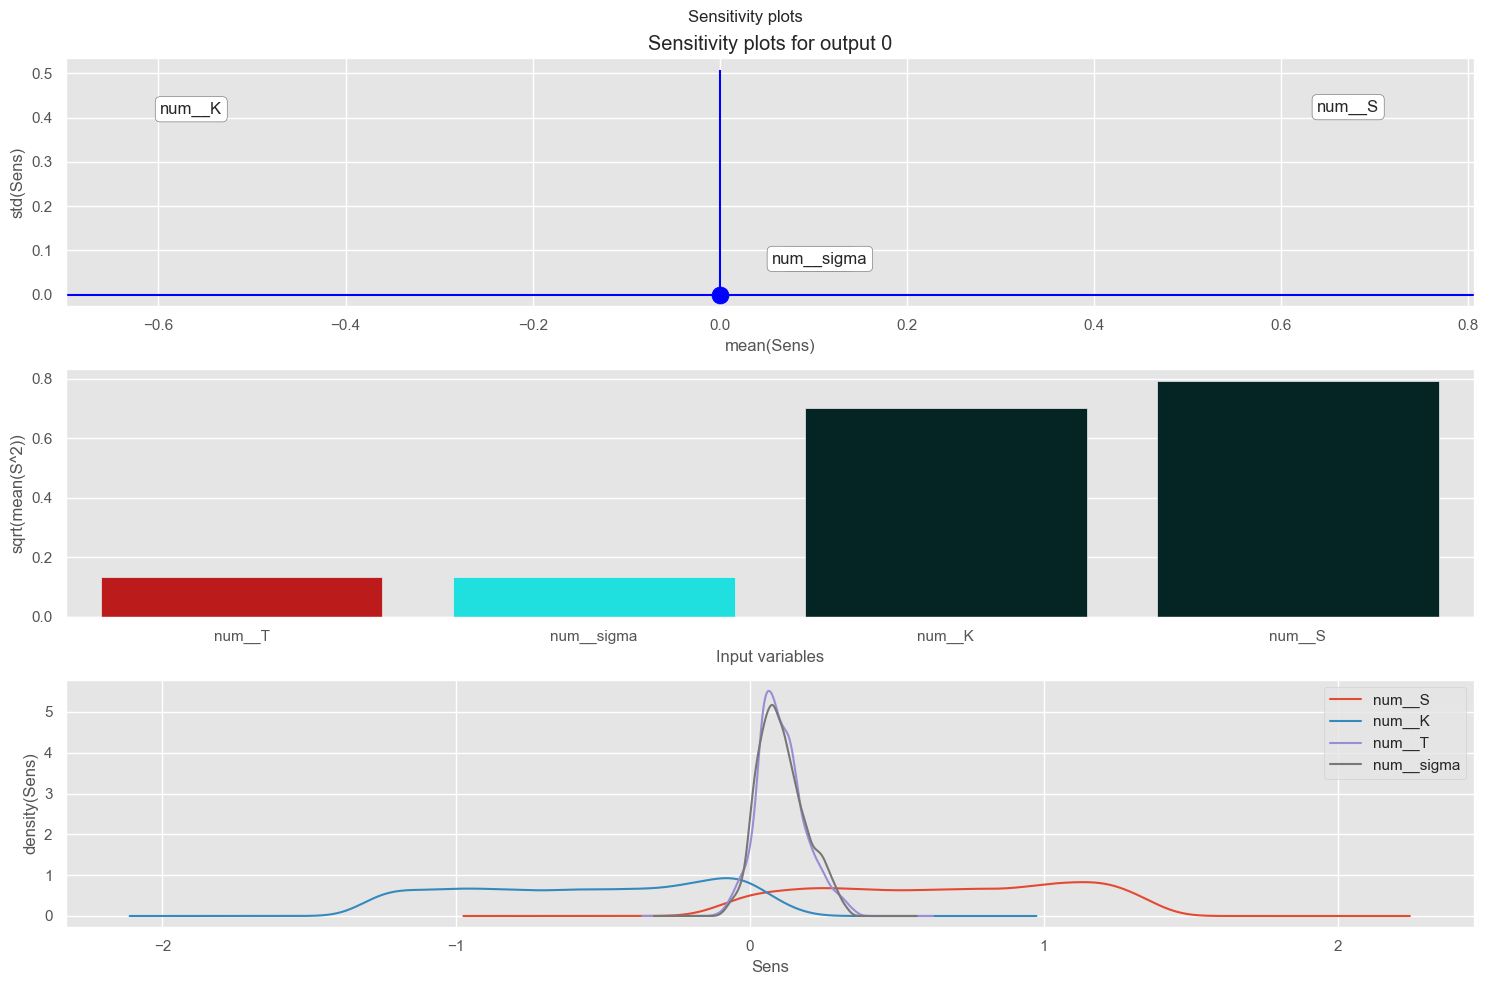

In [29]:
sensmlp.plot()

array([<Axes: xlabel='$\\alpha$', ylabel='$(ms_{X,j}^\\alpha(f))$'>,
       <Axes: >], dtype=object)

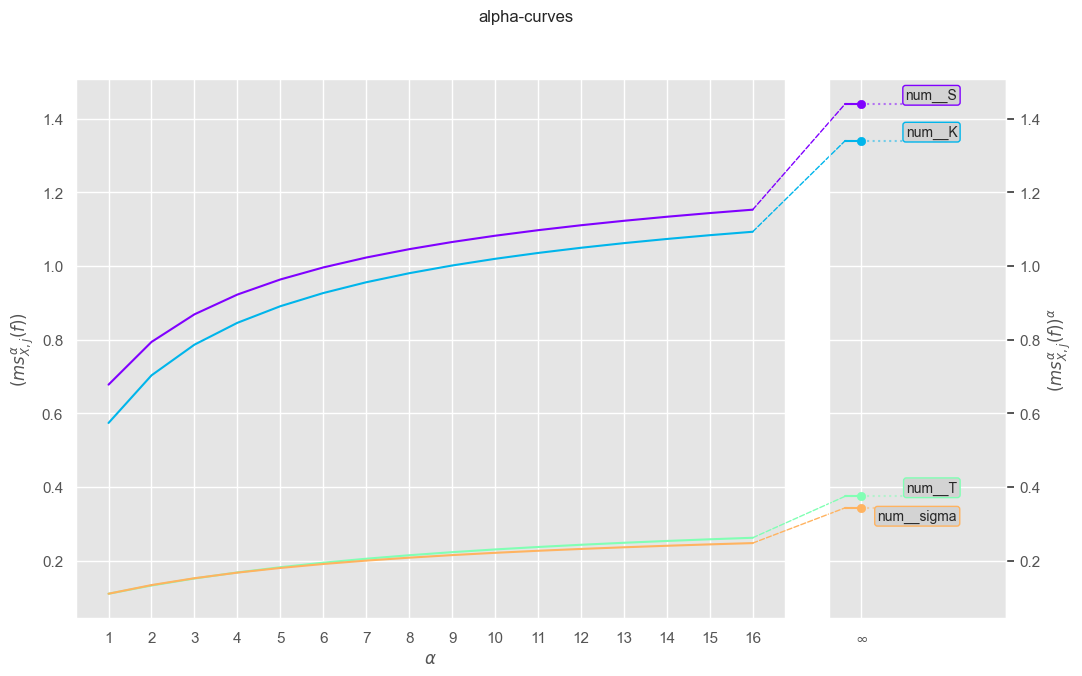

In [30]:
ns.alpha_sens_curves(sensmlp, figsize=(12, 7))

In [31]:
df_partDeriv = sensmlp.raw_sens[0]
df_partDeriv

,num__S,num__K,num__T,num__sigma
0,1.182945,-1.037168,-0.038803,0.033941
1,0.650335,-0.549236,0.027592,0.024408
2,0.750498,-0.672571,0.050684,0.084023
3,-0.031788,-0.005095,-0.049620,0.084142
4,0.336129,-0.219786,0.036005,0.035540
...,...,...,...,...
7995,0.942206,-0.837571,0.266543,0.146955
7996,1.240028,-1.108745,-0.053935,0.039861
7997,0.693236,-0.530702,0.148877,0.113101
7998,0.321314,-0.350189,0.109662,0.136393


Now it is necessary to descale the date because of the StandarScaler()

array([28.78190305, 29.01240073,  0.56018619,  0.11567188])

In [39]:
scales = scaler_X.scale_

# Supongamos que las columnas del neuralsense son:
# ['num__S', 'num__K', 'num__T', 'num__sigma']
columns = ['num__S', 'num__K', 'num__T', 'num__sigma']

# Desescalamos las derivadas:
for i, col in enumerate(columns):
    df_partDeriv[col + '_descaled'] = df_partDeriv[col] / scales[i]

In [40]:
df_partDeriv.describe()
df_partDeriv

,num__S,num__K,num__T,num__sigma,num__S_descaled,num__K_descaled,num__T_descaled,num__sigma_descaled
0,1.182945,-1.037168,-0.038803,0.033941,0.041100,-0.035749,-0.069268,0.293422
1,0.650335,-0.549236,0.027592,0.024408,0.022595,-0.018931,0.049255,0.211014
2,0.750498,-0.672571,0.050684,0.084023,0.026075,-0.023182,0.090477,0.726392
3,-0.031788,-0.005095,-0.049620,0.084142,-0.001104,-0.000176,-0.088578,0.727418
4,0.336129,-0.219786,0.036005,0.035540,0.011679,-0.007576,0.064273,0.307245
...,...,...,...,...,...,...,...,...
7995,0.942206,-0.837571,0.266543,0.146955,0.032736,-0.028869,0.475811,1.270443
7996,1.240028,-1.108745,-0.053935,0.039861,0.043084,-0.038216,-0.096281,0.344603
7997,0.693236,-0.530702,0.148877,0.113101,0.024086,-0.018292,0.265764,0.977775
7998,0.321314,-0.350189,0.109662,0.136393,0.011164,-0.012070,0.195760,1.179141


In [32]:
df_partDeriv.info()

print('Mean of partial derivatives:')
print(df_partDeriv.mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109444 entries, 0 to 109443
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   num__S               109444 non-null  float64
 1   num__K               109444 non-null  float64
 2   num__T               109444 non-null  float64
 3   num__sigma           109444 non-null  float64
 4   num__S_descaled      109444 non-null  float64
 5   num__K_descaled      109444 non-null  float64
 6   num__T_descaled      109444 non-null  float64
 7   num__sigma_descaled  109444 non-null  float64
dtypes: float64(8)
memory usage: 6.7 MB
Mean of partial derivatives:
num__S                 325.346297
num__K                -251.829046
num__T                  37.006430
num__sigma             -35.789174
num__S_descaled          0.525038
num__K_descaled         -0.420971
num__T_descaled         65.641988
num__sigma_descaled    -60.370504
dtype: float64


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_partial_derivative_distributions(df):
    """
    Dibuja histogramas con líneas de media y mediana para cada derivada parcial desescalada.
    
    Args:
        df (pd.DataFrame): DataFrame con columnas como num__S_descale, num__K_descale, etc.
    """
    # Filtramos solo columnas desescaladas
    cols = [col for col in df.columns if col.startswith('num__')]
    n_cols = len(cols)
    n_rows = (n_cols + 1) // 2  # dos columnas por fila
    
    plt.figure(figsize=(14, 5 * n_rows))
    
    for i, column in enumerate(cols, 1):
        plt.subplot(n_rows, 2, i)
        sns.histplot(df[column], kde=True, bins=100, color='steelblue')
        plt.axvline(df[column].mean(), color='red', linestyle='--', label=f"Mean: {df[column].mean():.2f}")
        plt.axvline(df[column].median(), color='green', linestyle=':', label=f"Median: {df[column].median():.2f}")
        
        # Extraemos el nombre original de la variable (S, K, T, sigma)
        feature_name = column.split('__')[-1].replace('_descale','')
        plt.title(f"∂Price/∂{feature_name}")
        
        plt.xlabel("Partial derivative value")
        plt.ylabel("Frequency")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

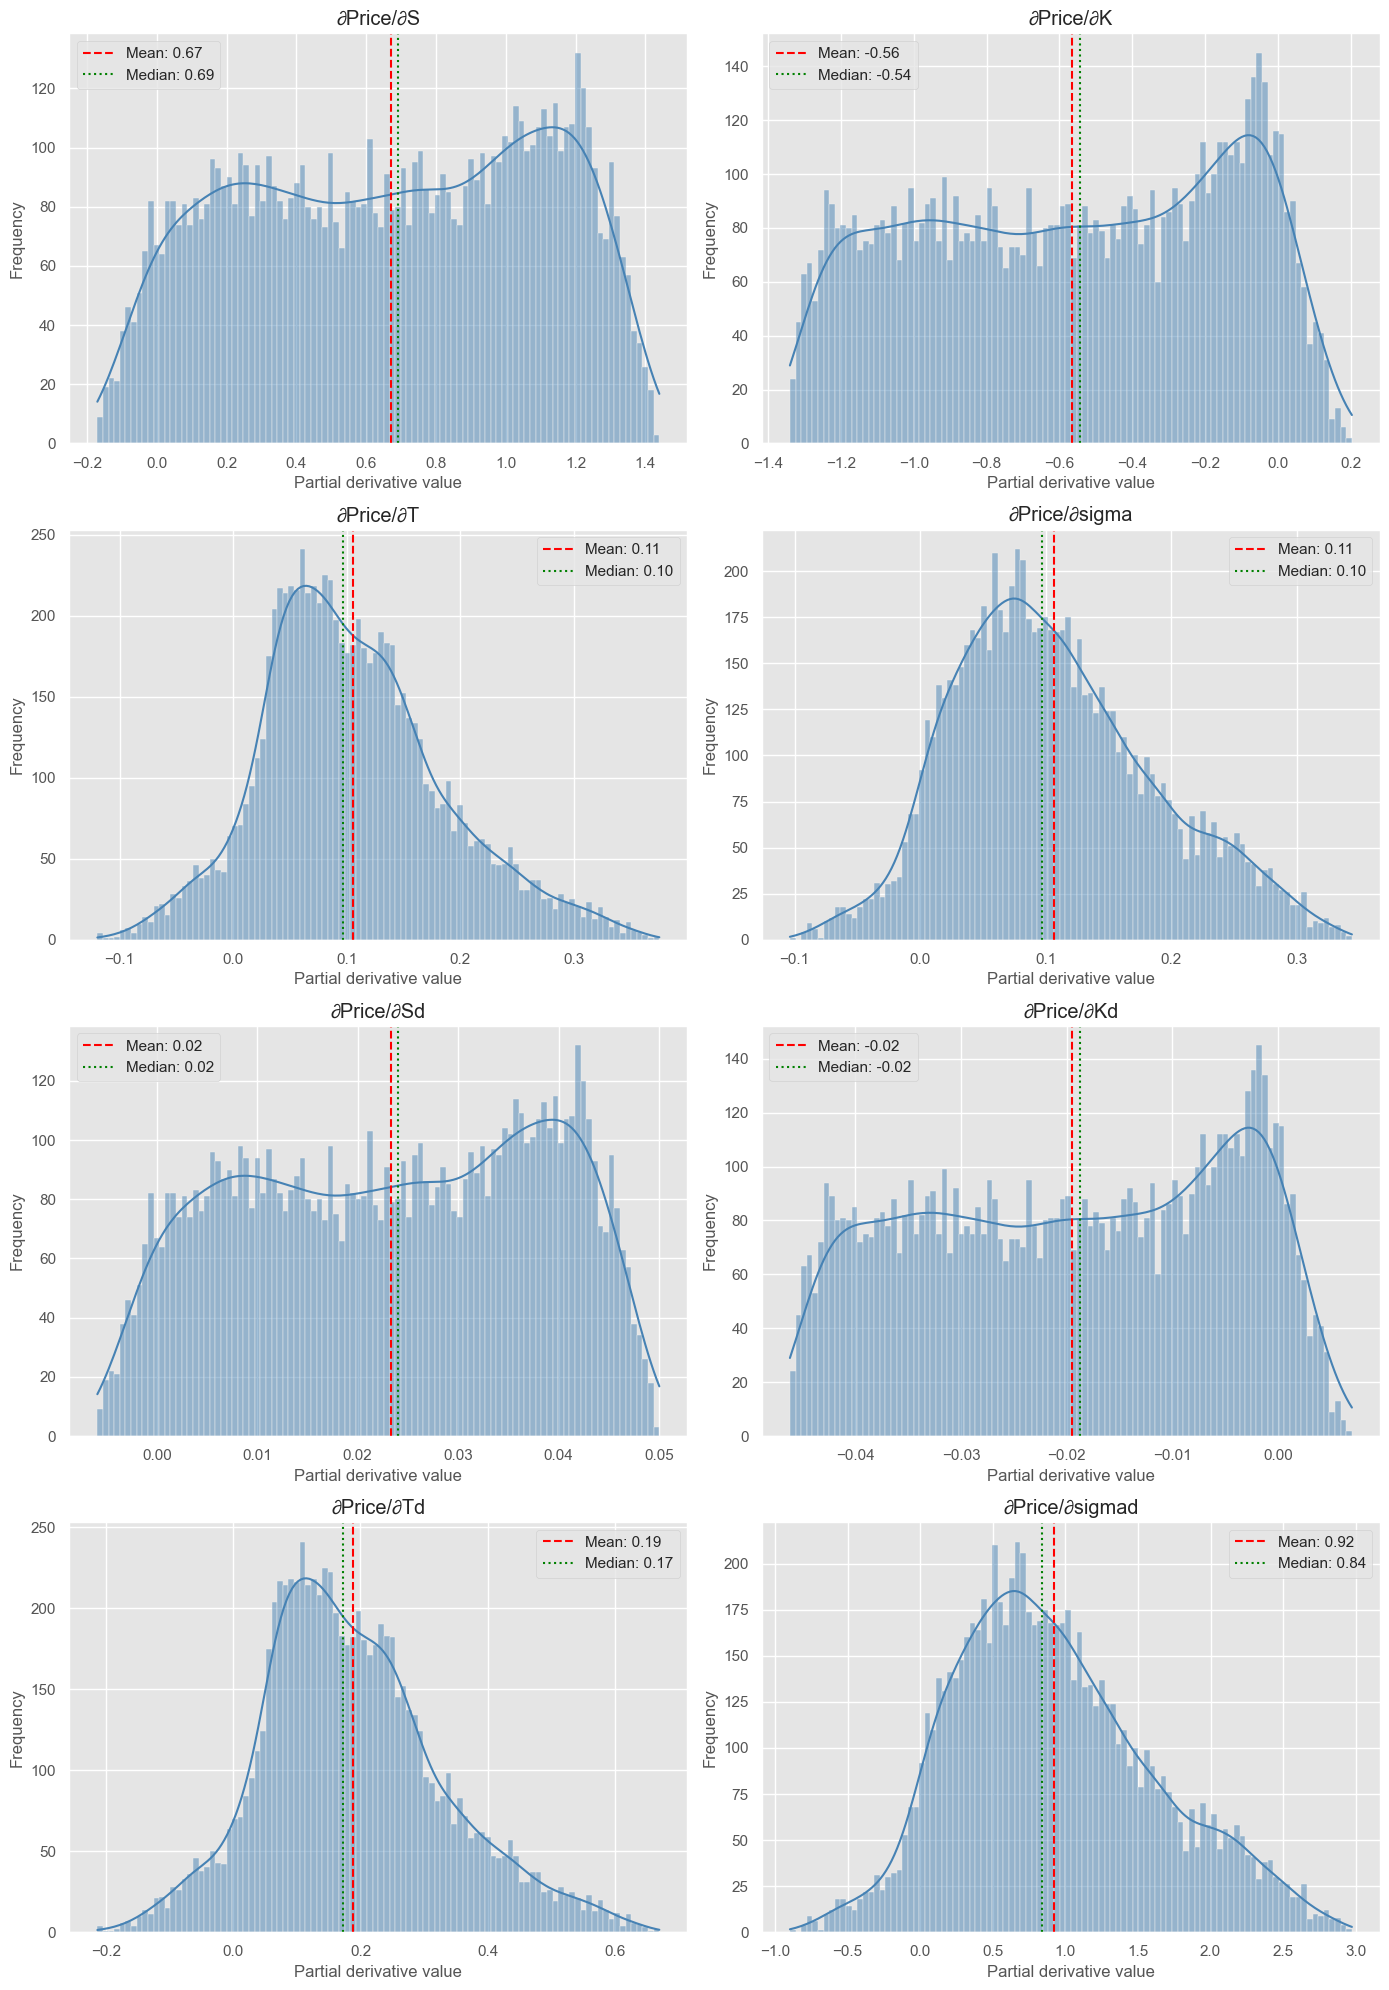

In [44]:
plot_partial_derivative_distributions(df_partDeriv)

In [35]:
def get_outliers_std(df, column, n_std=3):
    media = df[column].mean()
    std = df[column].std()
    return df[np.abs(df[column] - media) > n_std * std]

In [36]:
outliers_sigma = get_outliers_std(df_partDeriv, 'num__sigma', n_std=6)

## get a subdataframe with the outliers using the positional index in outlier_indices
outlier_rows = dfTR_eval.iloc[outliers_sigma.index]
outlier_rows = outlier_rows[outlier_rows['midPrice'] > 0]  # Filter out rows with midPrice <= 0
# Display the outlier rows
outlier_rows[outlier_rows['midPrice'] > 0].sort_values(by='residuals', ascending=True).head(50)


# Selecciona un caso aleatorio de los outliers detectados
random_case = outlier_rows.sample(1, random_state=0)
random_case.iloc[0]

KeyError: 'residuals'

In [66]:
outliers_T = get_outliers_std(df_partDeriv, 'num__T', n_std=3)
outlier_rows_T = dfTR_eval.iloc[outliers_T.index]
# Display the outlier rows for T


# Store the outlier rows in a CSV file
outlier_rows_T.reset_index(drop=True).to_csv('../data/predicted/outliers_T.csv', index=False)


In [67]:
outliers_S = get_outliers_std(df_partDeriv, 'num__S', n_std=3)
outlier_rows_S = dfTR_eval.iloc[outliers_S.index]
# Display the outlier rows for T
outlier_rows_S.value_counts("MLP_better")
# Store the outlier rows in a CSV file
outlier_rows_S.reset_index(drop=True).to_csv('../data/predicted/outliers_S.csv', index=False)

In [68]:
outliers_sigma = get_outliers_std(df_partDeriv, 'num__sigma', n_std=3)
outlier_rows_sigma = dfTR_eval.iloc[outliers_sigma.index]
# Display the outlier rows for T
outlier_rows_sigma.value_counts("MLP_better")
# Store the outlier rows in a CSV file
outlier_rows_sigma.reset_index(drop=True).to_csv('../data/predicted/outliers_sigma.csv', index=False)

In [40]:
from sklearn.metrics import mean_squared_error
import numpy as np

print("OUTLIERS de sigma")
print("\tBS_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_sigma['midPrice'], outlier_rows_sigma['BS_predict'])))
print("\tMLP_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_sigma['midPrice'], outlier_rows_sigma['MLP_pred'])))

print("OUTLIERS de T")
print("\tBS_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_T['midPrice'], outlier_rows_T['BS_predict'])))
print("\tMLP_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_T['midPrice'], outlier_rows_T['MLP_pred'])))

print("OUTLIERS de S")  
print("\tBS_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_S['midPrice'], outlier_rows_S['BS_predict'])))
print("\tMLP_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_S['midPrice'], outlier_rows_S['MLP_pred'])))

print("Numero de outliers de sigma:", len(outlier_rows_sigma))
print("Numero de outliers de T:", len(outlier_rows_T))
print("Numero de outliers de S:", len(outlier_rows_S))


OUTLIERS de sigma
	BS_diff RMSE: 161.89040831449233
	MLP_diff RMSE: 99.77888083095796
OUTLIERS de T
	BS_diff RMSE: 286.499021813977
	MLP_diff RMSE: 207.39905012548653
OUTLIERS de S
	BS_diff RMSE: 49.117329759204
	MLP_diff RMSE: 45.04007067790086
Numero de outliers de sigma: 4408
Numero de outliers de T: 2238
Numero de outliers de S: 1311


In [41]:
# Sacar las filas que no son outliers pero de dfTR
non_outliers_sigma = dfTR_eval[~df_partDeriv.index.isin(outliers_sigma.index)]
non_outliers_T = dfTR_eval[~df_partDeriv.index.isin(outliers_T.index)]
non_outliers_S = dfTR_eval[~df_partDeriv.index.isin(outliers_S.index)]

print("NO OUTLIERS de sigma")
print("\tBS_diff medio:", non_outliers_sigma['BS_diff'].mean())
print("\tBS_diff mediano:", non_outliers_sigma['BS_diff'].median())
print("\tMLP_diff medio:", non_outliers_sigma['MLP_diff'].mean())
print("\tMLP_diff mediano:", non_outliers_sigma['MLP_diff'].median())

print("NO OUTLIERS de T")
print("\tBS_diff medio:", non_outliers_T['BS_diff'].mean())
print("\tBS_diff mediano:", non_outliers_T['BS_diff'].median())
print("\tMLP_diff medio:", non_outliers_T['MLP_diff'].mean())
print("\tMLP_diff mediano:", non_outliers_T['MLP_diff'].median())

print("NO OUTLIERS de S")
print("\tBS_diff medio:", non_outliers_S['BS_diff'].mean())
print("\tBS_diff mediano:", non_outliers_S['BS_diff'].median())
print("\tMLP_diff medio:", non_outliers_S['MLP_diff'].mean())
print("\tMLP_diff mediano:", non_outliers_S['MLP_diff'].median())


NO OUTLIERS de sigma
	BS_diff medio: 9.196119192502444
	BS_diff mediano: 1.0956680475914586
	MLP_diff medio: 11.18008293129198
	MLP_diff mediano: 3.763415612009164
NO OUTLIERS de T
	BS_diff medio: 9.785390521568596
	BS_diff mediano: 1.2112988581907675
	MLP_diff medio: 11.080126799177146
	MLP_diff mediano: 3.853686501924539
NO OUTLIERS de S
	BS_diff medio: 10.742066208280814
	BS_diff mediano: 1.2067094119571635
	MLP_diff medio: 12.04997194632072
	MLP_diff mediano: 3.8965364287153106


In [42]:
# Calcular el mean de MLP_diff y BS_diff del dfTR_eval

print("\tBS_diff medio:", dfTS_eval['BS_diff'].mean())
print("\tBS_diff mediano:", dfTS_eval['BS_diff'].median())
print("\tMLP_diff medio:", dfTS_eval['MLP_diff'].mean())
print("\tMLP_diff mediano:", dfTS_eval['MLP_diff'].median())


	BS_diff medio: 10.757691945485645
	BS_diff mediano: 1.2022268983442839
	MLP_diff medio: 12.505041779484985
	MLP_diff mediano: 3.9419170025256456


In [46]:
dfTR_eval_prueba = dfTR_eval.copy()
# Calcular las griegas de Black-Scholes para los datos de entrenamiento
# Quiero añadir cada griega como una columna en dfTR_eval_prueba
greeks_df = dfTR_eval_prueba.apply(
    lambda row: pd.Series(greeks(row['S'], row['K'], row['T'], 0.045, row['sigma'])),
    axis=1
)
# Añadir las griegas al DataFrame
dfTR_eval_prueba = pd.concat([dfTR_eval_prueba, greeks_df], axis=1)
# Mostrar las primeras filas del DataFrame con las griegas añadidas
dfTR_eval_prueba.head()


,S,K,T,sigma,midPrice,Delta,Gamma,Vega,Theta,Rho
9254,127.081452,64.687451,1.901134,0.284611,65.501406,0.983617,0.000819,7.157120,-3.099206,108.300134
1561,73.687056,75.369683,0.391636,0.119589,2.037242,0.488520,0.072312,18.389191,-4.336314,13.304170
1670,88.062329,83.670567,0.980618,0.156852,9.334908,0.755255,0.022970,27.398709,-4.727327,55.264977
6087,70.598818,137.101429,1.619409,0.105033,0.000012,0.000007,0.000003,0.002746,-0.000110,0.000745
6669,63.031799,84.854665,0.300282,0.126241,0.000024,0.000024,0.000023,0.003517,-0.000806,0.000442


In [47]:
# Calcular Vega media
vega_mean = dfTR_eval_prueba['Vega'].mean()

# calcular Delta media
delta_mean = dfTR_eval_prueba['Delta'].mean()

# Calcular Theta media
theta_mean = dfTR_eval_prueba['Theta'].mean()

print("Vega media:", vega_mean)
print("Delta media:", delta_mean)
print("Theta media:", theta_mean)



Vega media: 19.82996248104808
Delta media: 0.5581109877832234
Theta media: -5.3323346942569545


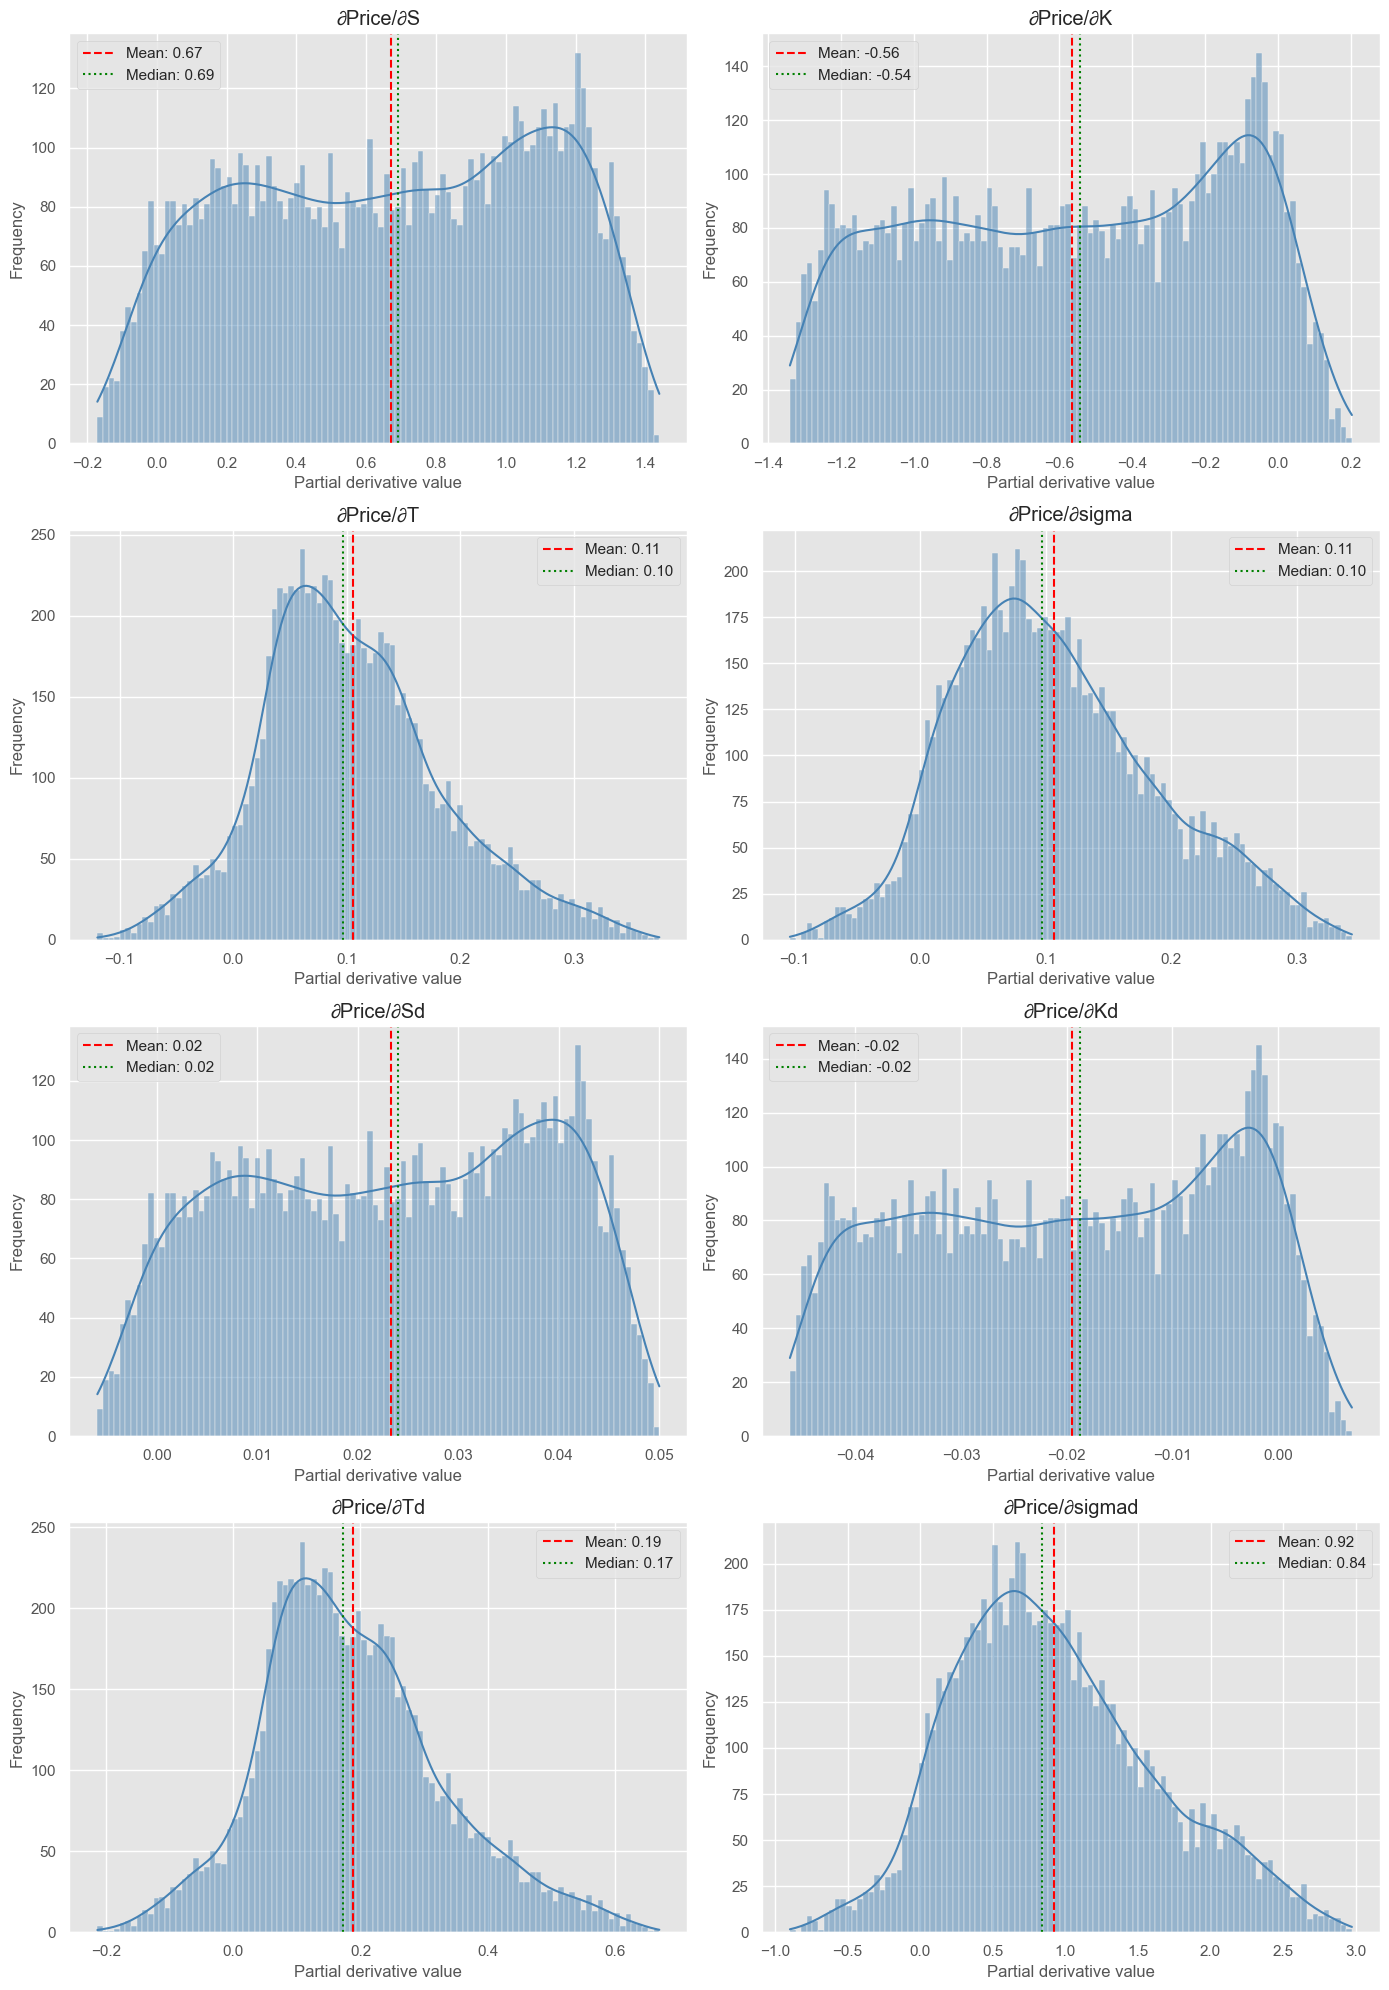

In [45]:
plot_partial_derivative_distributions(df_partDeriv)

### Analisis de outliers de sigma

In [73]:
outlier_rows_sigma

# Calculate greeks for the outliers
greeks_outliers_sigma = outlier_rows_sigma.apply(
    lambda row: pd.Series(greeks(row['S'], row['K'], row['T'], 0.045, row['sigma'])),
    axis=1
)
# Añadir las griegas al DataFrame de outliers
outlier_rows_sigma = pd.concat([outlier_rows_sigma, greeks_outliers_sigma], axis=1)
# Mostrar las primeras filas del DataFrame de outliers con las griegas añadidas
outlier_rows_sigma.head()

,S,K,T,sigma,midPrice,BS_predict,MLP_pred,MLP_diff,BS_diff,MLP_better,Delta,Gamma,Vega,Theta,Rho,Delta,Gamma,Vega,Theta,Rho
25108,198.14,55.0,0.608219,0.00001,133.4,144.624929,94.006589,39.393411,11.224929,False,1.0,0.0,0.0,-2.408178,32.548893,1.0,0.0,0.0,-2.408178,32.548893
46630,53.76,37.5,0.358904,0.00001,0.0,16.860786,17.674624,17.674624,16.860786,False,1.0,0.0,0.0,-1.660465,13.243280,1.0,0.0,0.0,-1.660465,13.243280
105590,170.34,155.0,0.186301,0.00001,0.0,16.634020,48.039198,48.039198,16.634020,False,1.0,0.0,0.0,-6.916769,28.635635,1.0,0.0,0.0,-6.916769,28.635635
20676,5614.61,3100.0,0.358904,0.00001,0.0,2564.274982,1665.026531,1665.026531,2564.274982,True,1.0,0.0,0.0,-137.265076,1094.777774,1.0,0.0,0.0,-137.265076,1094.777774
118719,167.10,87.5,0.531507,0.00001,33.8,81.667979,48.070726,14.270726,47.867979,True,1.0,0.0,0.0,-3.844441,45.407704,1.0,0.0,0.0,-3.844441,45.407704


In [74]:
outlier_rows_sigma.mean()

S             364.772430
K             259.166096
T               0.551816
sigma           0.009987
midPrice       87.872637
BS_predict    134.919389
MLP_pred       94.744911
MLP_diff       38.064781
BS_diff        47.047035
MLP_better      0.480263
Delta           0.954773
Gamma           0.000351
Vega           17.274714
Theta         -11.351784
Rho           116.734476
Delta           0.954773
Gamma           0.000351
Vega           17.274714
Theta         -11.351784
Rho           116.734476
dtype: float64

In [77]:
outliers_sigma.mean()

num__S                  167.910360
num__K                 -194.780634
num__T                    0.493818
num__sigma            -1357.331552
num__S_descaled           0.270971
num__K_descaled          -0.325606
num__T_descaled           0.875934
num__sigma_descaled   -2289.597116
dtype: float64

### Analisis de outliers de S (Delta)

In [81]:
outlier_rows_S

,S,K,T,sigma,midPrice,BS_predict,MLP_pred,MLP_diff,BS_diff,MLP_better
39747,217.53,270.0,0.358904,0.062509,0.00,7.406839e-08,4.480155,4.480155,7.406839e-08,False
46630,53.76,37.5,0.358904,0.000010,0.00,1.686079e+01,17.674624,17.674624,1.686079e+01,False
78280,230.01,190.0,0.109589,0.000010,29.45,4.094468e+01,56.843859,27.393859,1.149468e+01,False
14124,97.25,640.0,1.605479,0.250007,0.00,6.643459e-08,43.680998,43.680998,6.643459e-08,False
54668,49.79,30.0,0.358904,0.000010,0.00,2.027063e+01,17.638841,17.638841,2.027063e+01,True
...,...,...,...,...,...,...,...,...,...,...
125899,465.64,560.0,0.780822,0.031260,0.00,7.676016e-08,132.643460,132.643460,7.676016e-08,False
66040,47.35,30.0,0.608219,0.000010,16.20,1.815996e+01,16.310129,0.110129,1.959961e+00,True
105983,100.23,140.0,1.605479,0.062509,0.00,1.120675e-03,13.950485,13.950485,1.120675e-03,False
124358,40.66,22.5,0.780822,0.000010,13.65,1.893685e+01,13.540218,0.109782,5.286854e+00,True
